In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import json

import sys
sys.path.append('../')
from helpers import cm2inch, title, show_num_contours, load_datasets
from melodic_contour import *
matplotlib.style.use('styles.mplstyle')

from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
import tslearn
from tslearn.metrics import cdist_dtw

from scipy.spatial import distance_matrix
from unidip.dip import diptst as diptest

/Users/bas/repos/papers/contour-typology/env/lib/python3.7/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
maidu = pd.read_csv('densmore/maidu.csv')
menominee = pd.read_csv('densmore/menominee.csv')
choctaw = pd.read_csv('densmore/choctaw.csv')
nootka = pd.read_csv('densmore/nootka.csv')
ute = pd.read_csv('densmore/ute.csv')
papago = pd.read_csv('densmore/papago.csv')

In [3]:
dfs = dict(
    maidu = pd.read_csv('densmore/maidu.csv'),
    menominee = pd.read_csv('densmore/menominee.csv'),
    choctaw = pd.read_csv('densmore/choctaw.csv'),
    nootka = pd.read_csv('densmore/nootka.csv'),
    ute = pd.read_csv('densmore/ute.csv'),
    papago = pd.read_csv('densmore/papago.csv')
)

## Meters

In [226]:
def get_meters(df):
    not_na = df['meters'].isna() == False
    meters = df[not_na]['meters'].str.split('|')
    return [m for ms in meters for m in ms if m not in 
            ['', 'free', '3/5', '4/3']]

In [227]:
meters = dict()
for culture in dfs:
    try:
        meters[culture] = get_meters(dfs[culture])
    except:
        print(culture, 'failed')

In [228]:
all_meters = [m for ms in list(meters.values()) for m in ms]
unique_meters = sorted(list(set(all_meters)))

In [326]:
meter_counts = []
for culture in dfs:
    counts = pd.value_counts(meters[culture])
    meter_counts.append([counts.get(m, 0) for m in unique_meters])
counts = np.array(meter_counts)
counts = counts / counts.sum(axis=1)[:, np.newaxis]

In [325]:
data = []
for culture in dfs:
    data.extend([(culture, m) for m in meters[culture]])

In [230]:
df = pd.DataFrame(data, columns=['culture', 'meter'])

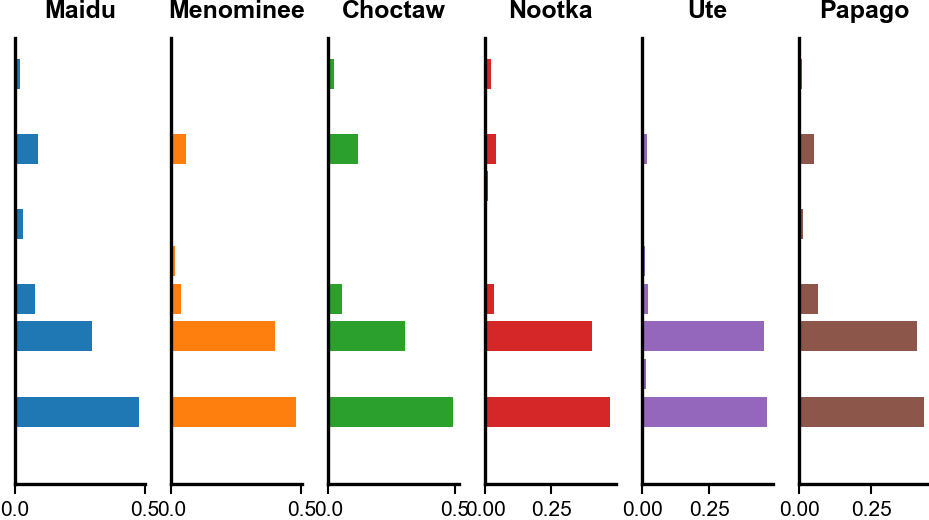

In [330]:
plt.figure(figsize=cm2inch(10, 5))
for i, culture in enumerate(dfs.keys()):
    plt.subplot(int(f'1{len(dfs)}{i+1}'))
    plt.title(culture[0].upper()+culture[1:])
    plt.barh(range(len(unique_meters)), counts[i, :], color=f'C{i}')
    plt.yticks([])

# plt.subplot(152)
# plt.title(list(dfs.keys())[1])
# plt.barh(range(len(unique_meters)), counts[1,:], color='C1')
# plt.yticks([])

# plt.subplot(153)
# plt.barh(range(len(unique_meters)), counts[2,:], color='C2')
# plt.yticks([])

# plt.subplot(154)
# plt.barh(range(len(unique_meters)), counts[3,:], color='C3')
# plt.yticks([])


/Users/bas/repos/papers/contour-typology/env/lib/python3.7/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


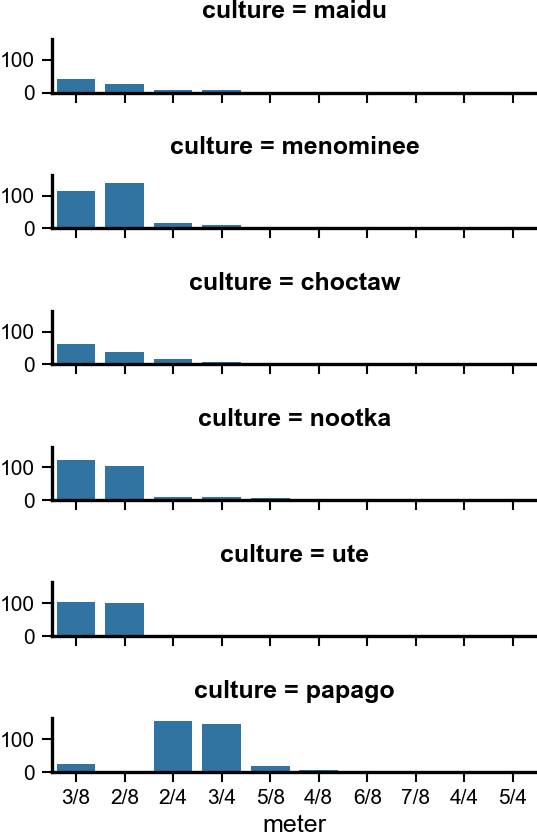

In [320]:
g = sns.FacetGrid(df, row="culture", aspect=4, height=.5)
g.map(sns.countplot, "meter")

In [261]:
g.map?

Signature: g.map(func, *args, **kwargs)
Docstring:
Apply a plotting function to each facet's subset of the data.

Parameters
----------
func : callable
    A plotting function that takes data and keyword arguments. It
    must plot to the currently active matplotlib Axes and take a
    `color` keyword argument. If faceting on the `hue` dimension,
    it must also take a `label` keyword argument.
args : strings
    Column names in self.data that identify variables with data to
    plot. The data for each variable is passed to `func` in the
    order the variables are specified in the call.
kwargs : keyword arguments
    All keyword arguments are passed to the plotting function.

Returns
-------
self : object
    Returns self.
File:      ~/repos/papers/contour-typology/env/lib/python3.7/site-packages/seaborn/axisgrid.py
Type:      method


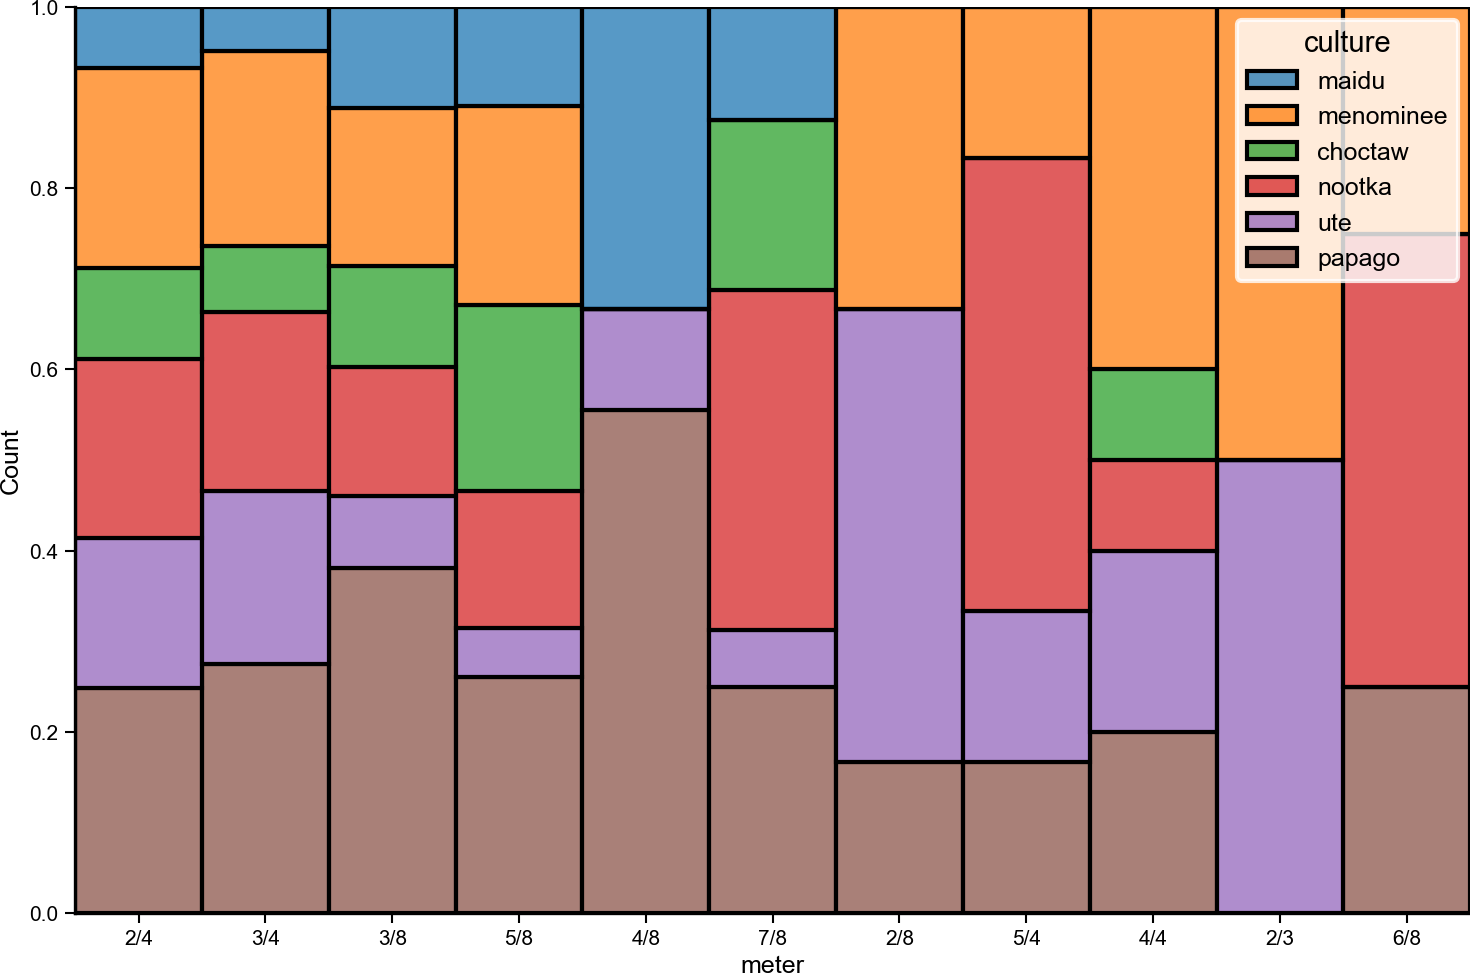

In [249]:
sns.histplot(df, x='meter', hue='culture', multiple='fill',)

In [193]:
sns.histplot(counts[0])

array([[  0,  42,   0,  26,   0,   7,   0,   0,   3,   0,   8,   0,   2],
       [  1, 139,   2, 115,   0,  11,   0,   4,   0,   1,  16,   1,   0],
       [  0,  63,   0,  39,   0,   7,   0,   1,   0,   0,  15,   0,   3],
       [  0, 124,   0, 106,   0,   9,   0,   1,   0,   3,  11,   2,   6],
       [  1, 104,   3, 102,   0,   5,   0,   2,   1,   1,   4,   0,   1],
       [  0, 156,   1, 147,   1,  24,   1,   2,   5,   1,  19,   1,   4]])

In [156]:
[m for meters in dfs['choctaw']['meters'].str.split('|') for m in meters]

TypeError: 'float' object is not iterable

## Tempi

In [4]:
def get_tempi(df, col='bpm_voice'):
    if not col in df.columns:
        col = 'bpm'
    try:
        single_value = df[col].str.contains("\|") == False
    except:
        single_value = True
    not_null = df[col].isna() == False
    subset = df[single_value & not_null]
    tempi = subset[col].astype(int)
#     tempi *= subset['beat_duration']
    return np.array(tempi)


In [5]:
tempi = dict()
for culture in dfs:
    try:
        tempi[culture] = get_tempi(dfs[culture])
    except:
        print(culture, 'failed')

In [8]:
dip, pval, (left_idx, right_idx) = diptest(np.msort(tempi['maidu']), is_hist=False, numt=1000)
pval

0.03296703296703297

In [9]:
tidy = []
for culture in dfs:
    tidy.extend([(culture, t) for t in tempi[culture]])
tempi_df = pd.DataFrame(tidy, columns=['culture', 'bpm'])

In [10]:
jitter = 5 * np.random.randn(len(tempi_df))
tempi_df['bpm_jitter'] = tempi_df['bpm'] + jitter

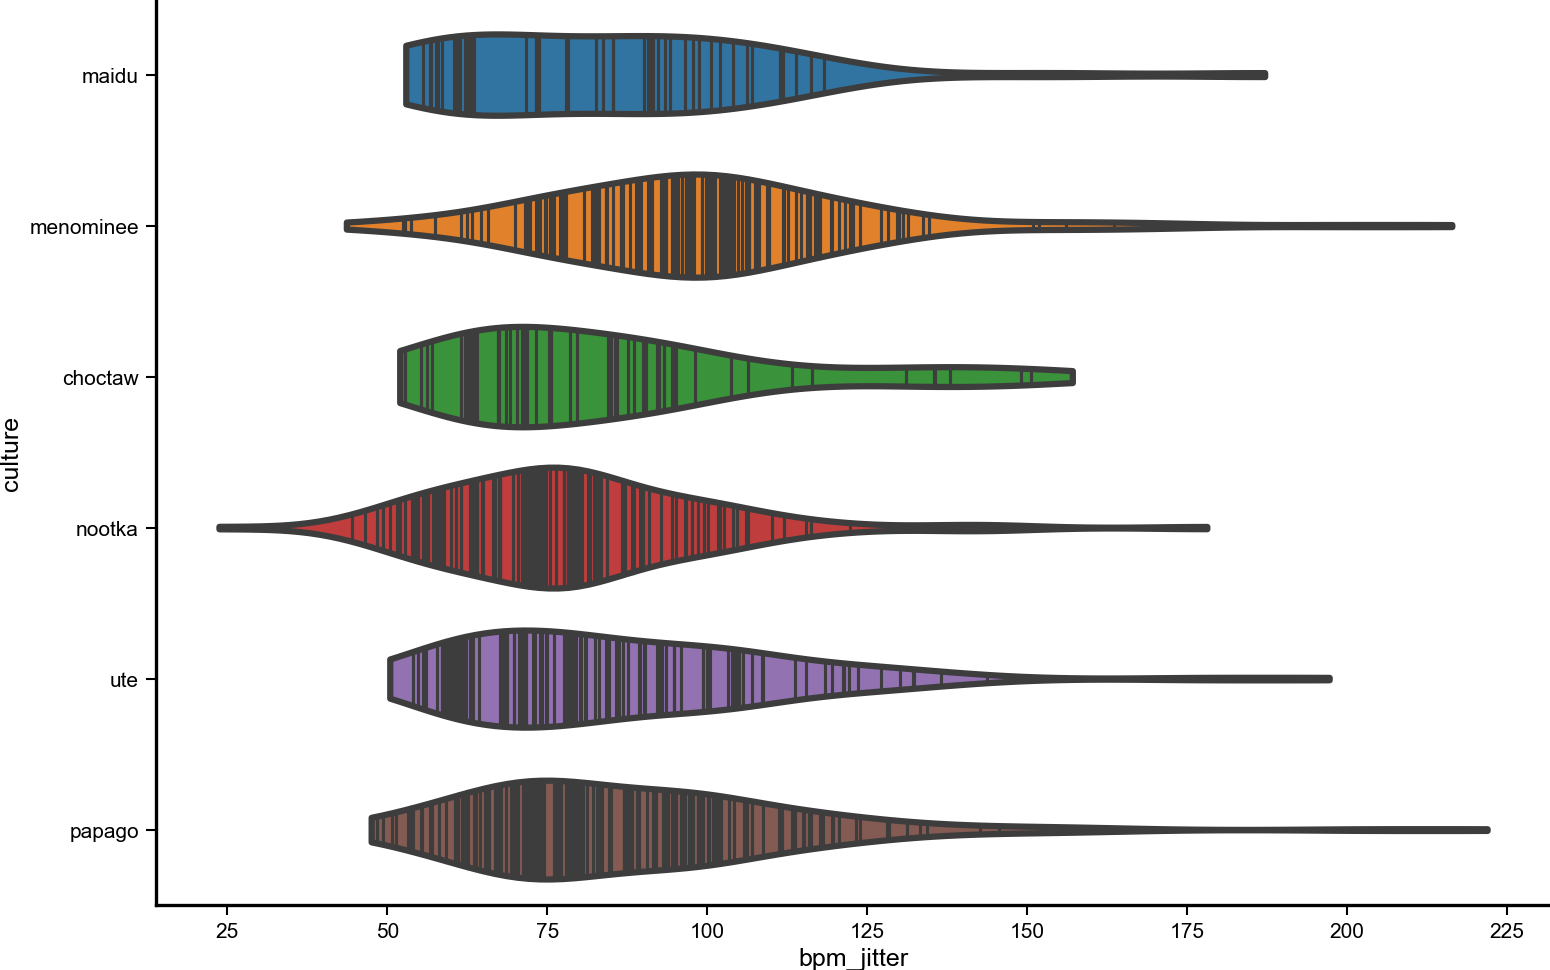

In [11]:
sns.violinplot(data=tempi_df, x='bpm_jitter', y='culture', inner='stick', cut=0)

In [87]:
N = np.min([len(tempi['maidu']), len(tempi['menominee']), len(tempi['nootka'])])
np.random.seed(0)
combined = np.concatenate([
    np.random.choice(tempi['maidu'], N, replace=False),
    np.random.choice(tempi['menominee'], N, replace=False),
    np.random.choice(tempi['nootka'], N, replace=False)
])

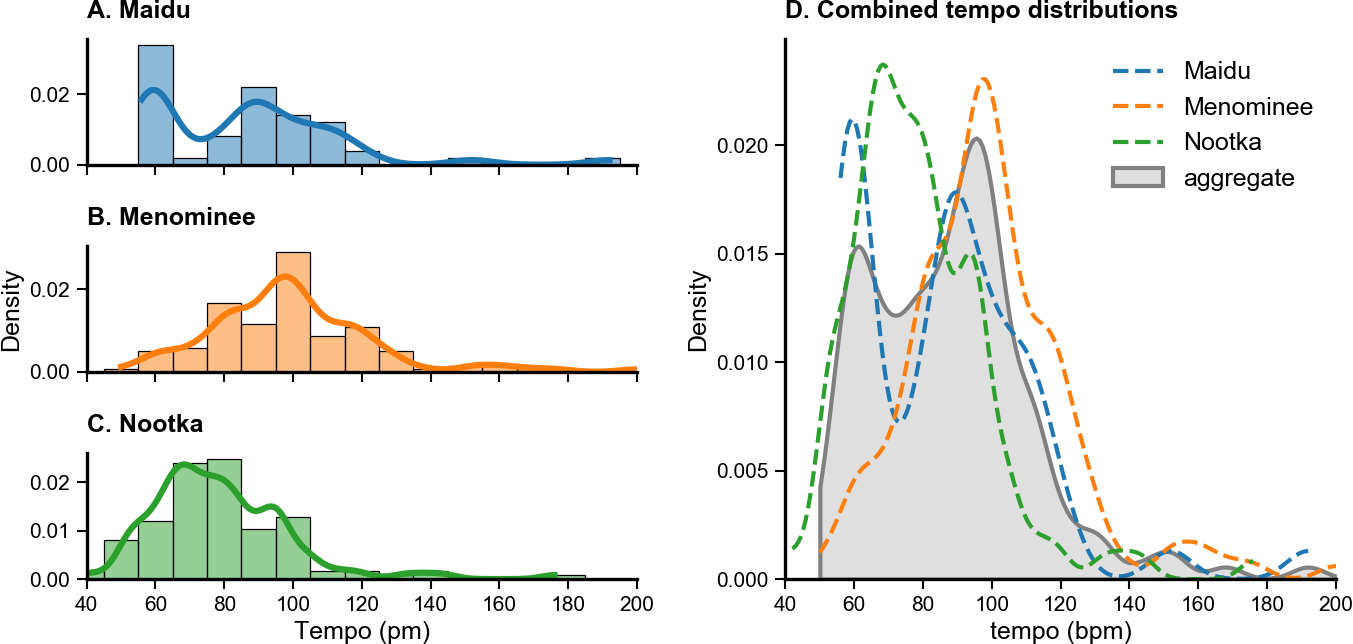

In [88]:
fig = plt.figure(figsize=cm2inch(12, 6))
g = plt.GridSpec(3, 2)

props = dict(kde_kws=dict(cut=0, bw_adjust=.5), kde=True, binwidth=10, binrange=(35, 225), lw=.3, stat='density')

ax1 = fig.add_subplot(g[0, 0])
title('A. Maidu')
sns.histplot(tempi['maidu'], **props)
ax1.set_xticklabels([])
plt.ylabel('')
plt.xlim(40, 200)

ax2 = fig.add_subplot(g[1, 0])
title('B. Menominee')
sns.histplot(tempi['menominee'], **props, color='C1')
ax2.set_xticklabels([])
plt.xlim(40, 200)

ax3 = fig.add_subplot(g[2, 0])
title('C. Nootka')
sns.histplot(tempi['nootka'], **props, color='C2')
plt.xlabel('Tempo (pm)')
plt.ylabel('')
plt.xlim(40, 200)

ax4 = fig.add_subplot(g[:, 1])
bw_adjust = .5
sns.kdeplot(combined, cut=0, color='.5', fill=True, label='aggregate', bw_adjust=bw_adjust)
sns.kdeplot(tempi['maidu'], cut=0, label='Maidu', lw=1, ls='--', bw_adjust=bw_adjust)
sns.kdeplot(tempi['menominee'], cut=0, label='Menominee',ls='--', lw=1, bw_adjust=bw_adjust)
sns.kdeplot(tempi['nootka'], cut=0, label='Nootka', lw=1, ls='--',bw_adjust=bw_adjust)
plt.legend()
plt.xlabel('tempo (bpm)')
title('D. Combined tempo distributions')
plt.xlim(40, 200)

plt.tight_layout()
plt.savefig('../figures/figZ1-tempo-distributions.pdf')

In [48]:
dip, pval, (left_idx, right_idx) = diptest(np.msort(tempi['maidu']), is_hist=False, numt=1000)
print('maidu', pval)

maidu 0.027972027972027972


In [54]:
dip, pval, (left_idx, right_idx) = diptest(np.msort(tempi['nootka']), is_hist=False, numt=1000)
print('nootka', pval, (left_idx, right_idx))

nootka 0.942057942057942 (10, 12)


In [82]:
dip, pval, (left_idx, right_idx) = diptest(np.msort(tempi['menominee']), is_hist=False, numt=1000)
print('menominee', pval, left_idx, right_idx)

menominee 0.5644355644355644 14 14


In [97]:
dip, pval, (left_idx, right_idx) = diptest(np.msort(combined), is_hist=False, numt=1000)
print('Combined', pval, left_idx, right_idx)

Combined 0.8491508491508492 13 16


In [214]:
plt.annotate?

Signature: plt.annotate(s, xy, *args, **kwargs)
Docstring:
Annotate the point *xy* with text *text*.

In the simplest form, the text is placed at *xy*.

Optionally, the text can be displayed in another position *xytext*.
An arrow pointing from the text to the annotated point *xy* can then
be added by defining *arrowprops*.

Parameters
----------
text : str
    The text of the annotation.  *s* is a deprecated synonym for this
    parameter.

xy : (float, float)
    The point *(x,y)* to annotate.

xytext : (float, float), optional
    The position *(x,y)* to place the text at.
    If *None*, defaults to *xy*.

xycoords : str, `.Artist`, `.Transform`, callable or tuple, optional

    The coordinate system that *xy* is given in. The following types
    of values are supported:

    - One of the following strings:

      =================   =============================================
      Value               Description
      =================   ==========================================

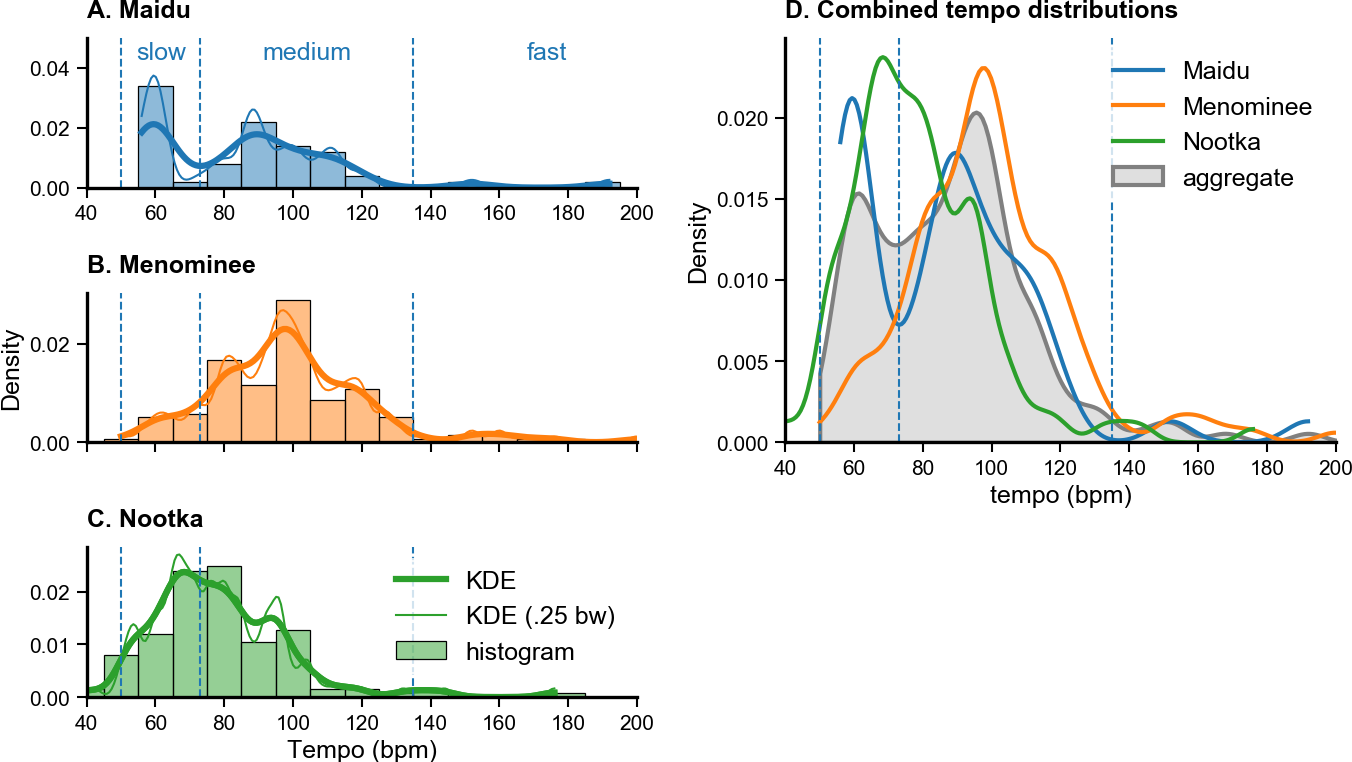

In [240]:
def maidu_categories():
    plt.axvline(50, c='C0', ls='--', lw=.5)
    plt.axvline(73, c='C0', ls='--', lw=.5)
    plt.axvline(135, c='C0', ls='--', lw=.5)
    
fig = plt.figure(figsize=cm2inch(12, 7))
g = plt.GridSpec(3, 2)

props = dict(kde_kws=dict(cut=0, bw_adjust=.5), kde=True, binwidth=10, binrange=(35, 225), lw=.3, stat='density')

ax1 = fig.add_subplot(g[0, 0])
title('A. Maidu')
sns.histplot(tempi['maidu'], **props, label='histogram')
sns.kdeplot(tempi['maidu'], cut=0, color='C0', bw_adjust=.25, lw=.5)
plt.ylim(0, 0.05)
# ax1.set_xticklabels([])
plt.ylabel('')
maidu_categories()
plt.xlim(40, 200)
textprops = dict(xycoords='axes fraction', xytext=(0, -5), textcoords='offset points',
            color='C0', fontsize=6)
plt.annotate('slow', (.09, 1), **textprops)
plt.annotate('medium', (.32, 1), **textprops)
plt.annotate('fast', (.8, 1), **textprops)

ax2 = fig.add_subplot(g[1, 0])
title('B. Menominee')
sns.histplot(tempi['menominee'], **props, color='C1')
sns.kdeplot(tempi['menominee'], cut=0, bw_adjust=.25, lw=.5, color='C1')

ax2.set_xticklabels([])
maidu_categories()
plt.xlim(40, 200)

ax3 = fig.add_subplot(g[2, 0])
title('C. Nootka')
sns.histplot(tempi['nootka'], **props, color='C2', label='histogram')
sns.kdeplot(tempi['nootka'], cut=0, bw_adjust=.5, color='C2', label='KDE')
sns.kdeplot(tempi['nootka'], cut=0, bw_adjust=.25, lw=.5, color='C2', label='KDE (.25 bw)')
plt.xlabel('Tempo (bpm)')
plt.ylabel('')
plt.legend()
maidu_categories()
plt.xlim(40, 200)

ax4 = fig.add_subplot(g[:2, 1])
bw_adjust = .5
sns.kdeplot(combined, cut=0, color='.5', fill=True, label='aggregate', bw_adjust=bw_adjust)
sns.kdeplot(tempi['maidu'], cut=0, label='Maidu', lw=1, ls='-', bw_adjust=bw_adjust)
sns.kdeplot(tempi['menominee'], cut=0, label='Menominee',ls='-', lw=1, bw_adjust=bw_adjust)
sns.kdeplot(tempi['nootka'], cut=0, label='Nootka', lw=1, ls='-',bw_adjust=bw_adjust)
plt.legend()
plt.xlabel('tempo (bpm)')
title('D. Combined tempo distributions')
maidu_categories()

plt.xlim(40, 200)


plt.tight_layout()
plt.savefig('../figures/figZ1-tempo-distributions.pdf')

/Users/bas/repos/papers/contour-typology/env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


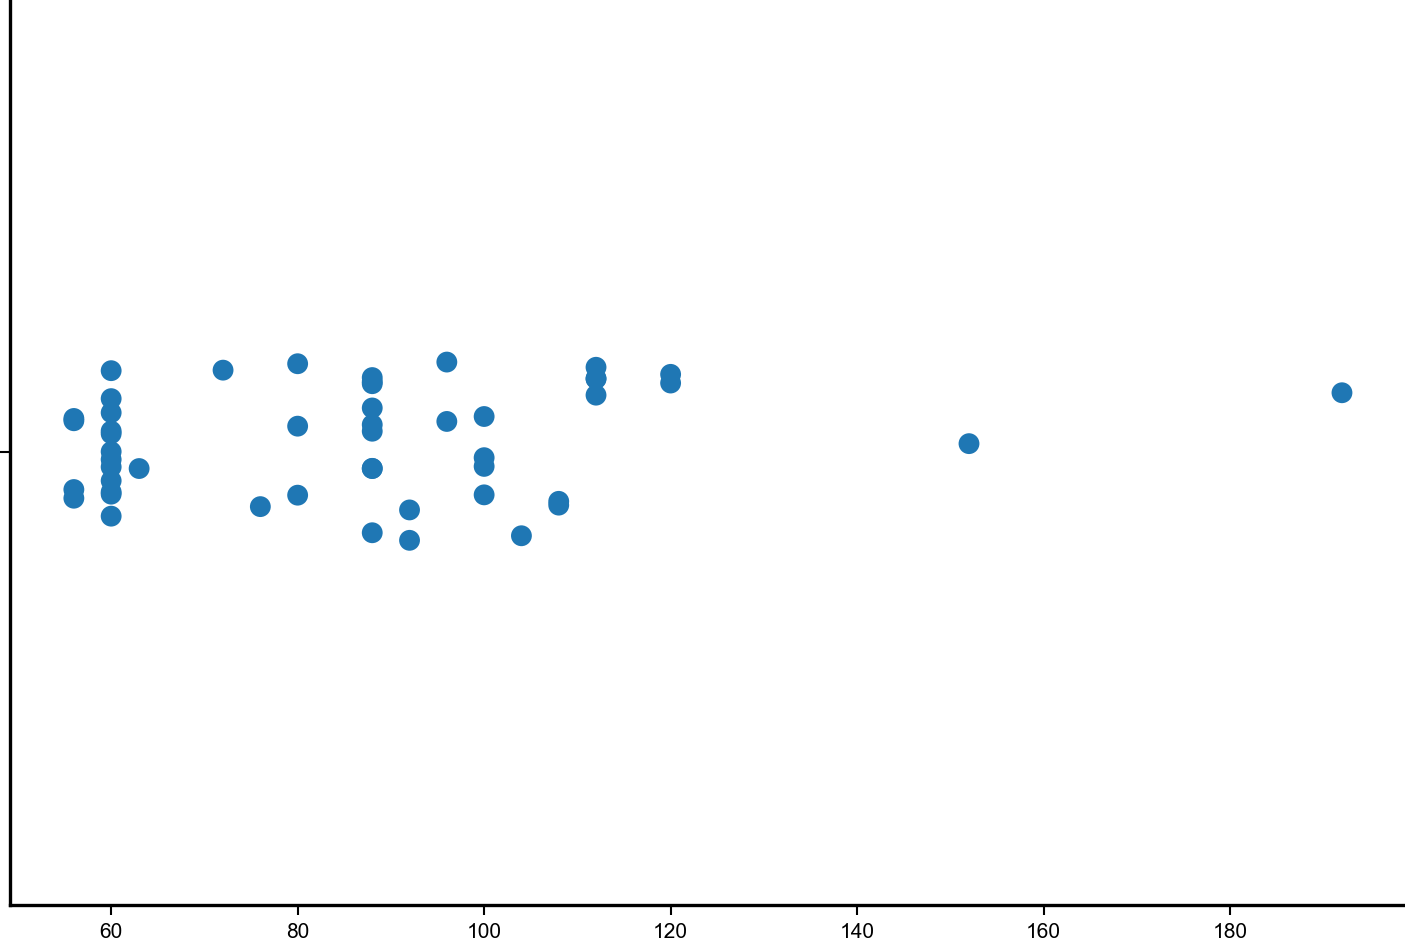

In [156]:
sns.stripplot(tempi['maidu'])

## Vertical version

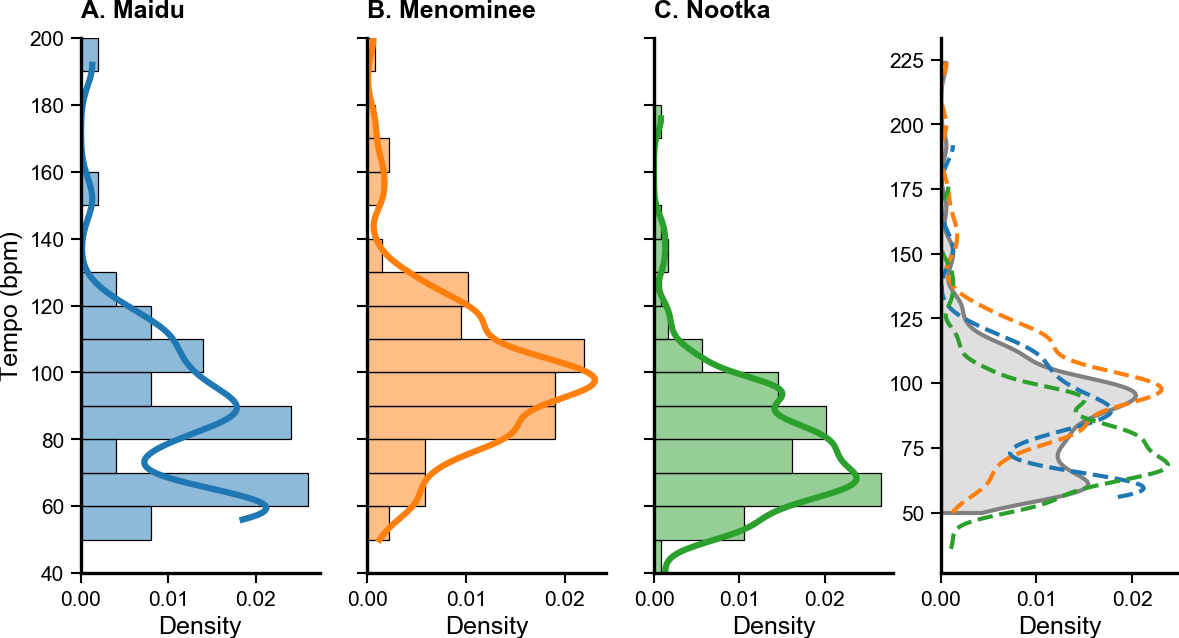

In [132]:
fig = plt.figure(figsize=cm2inch(12, 6))
g = plt.GridSpec(1, 4)

props = dict(kde_kws=dict(cut=0, bw_adjust=.5), kde=True, binwidth=10, binrange=(40, 200), lw=.3, stat='density')

ax1 = fig.add_subplot(g[0, 0])
title('A. Maidu')
sns.histplot(y=tempi['maidu'], **props)
# ax1.set_xticklabels([])
plt.ylabel('Tempo (bpm)')
plt.ylim(40, 200)

ax2 = fig.add_subplot(g[0, 1])
title('B. Menominee')
sns.histplot(y=tempi['menominee'], **props, color='C1')
ax2.set_yticklabels([])
plt.ylim(40, 200)

ax3 = fig.add_subplot(g[0, 2], sharey=ax2)
title('C. Nootka')
sns.histplot(y=tempi['nootka'], **props, color='C2')
plt.ylim(40, 200)

ax4 = fig.add_subplot(g[0, 3])
bw_adjust = .5
sns.kdeplot(y=combined, cut=0, color='.5', fill=True, label='aggregate', bw_adjust=bw_adjust)
sns.kdeplot(y=tempi['maidu'], cut=0, label='Maidu', lw=1, ls='--', bw_adjust=bw_adjust)
sns.kdeplot(y=tempi['menominee'], cut=0, label='Menominee',ls='--', lw=1, bw_adjust=bw_adjust)
sns.kdeplot(y=tempi['nootka'], cut=0, label='Nootka', lw=1, ls='--',bw_adjust=bw_adjust)
# plt.legend()
# plt.xlabel('tempo (bpm)')
# title('D. Combined tempo distributions')
# plt.xlim(40, 200)

# plt.tight_layout()
# plt.savefig('../figures/figZ1-tempo-distributions.pdf')

## Bla

### sns.kdeplot(combined, vertical=True)
sns.histplot(y=combined, kde=True)

(40, 160)

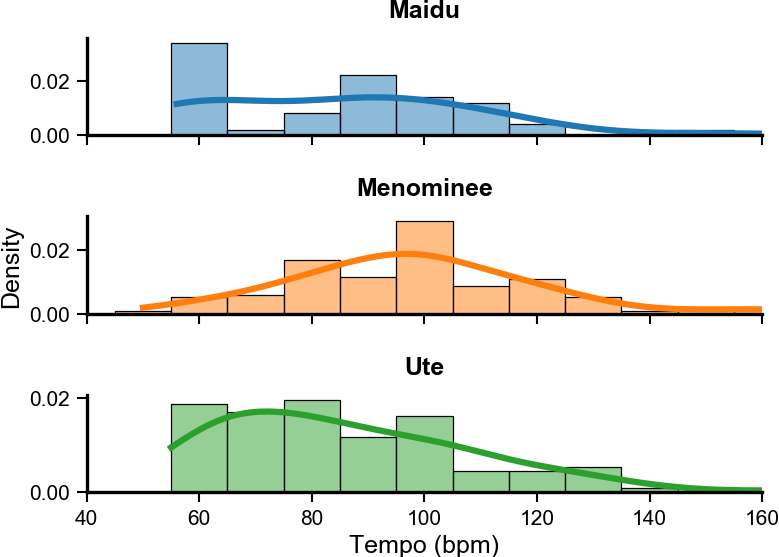

In [552]:
plt.figure(figsize=cm2inch(7, 5))

props = dict(kde_kws=dict(cut=0), kde=True, binwidth=10, binrange=(35, 225), lw=.3, stat='density')
ax1 = plt.subplot(311)
plt.title('Maidu')
sns.histplot(tempi['maidu'], **props)
ax1.set_xticklabels([])
plt.ylabel('')
plt.xlim(40, 160)

ax2 = plt.subplot(312)
plt.title('Menominee')
sns.histplot(tempi['menominee'], **props, color='C1')
ax2.set_xticklabels([])
plt.xlim(40, 160)

ax3 = plt.subplot(313)
plt.title('Ute')
sns.histplot(tempi['ute'], **props, color='C2')
plt.tight_layout()
plt.xlabel('Tempo (bpm)')
plt.ylabel('')
plt.xlim(40, 160)


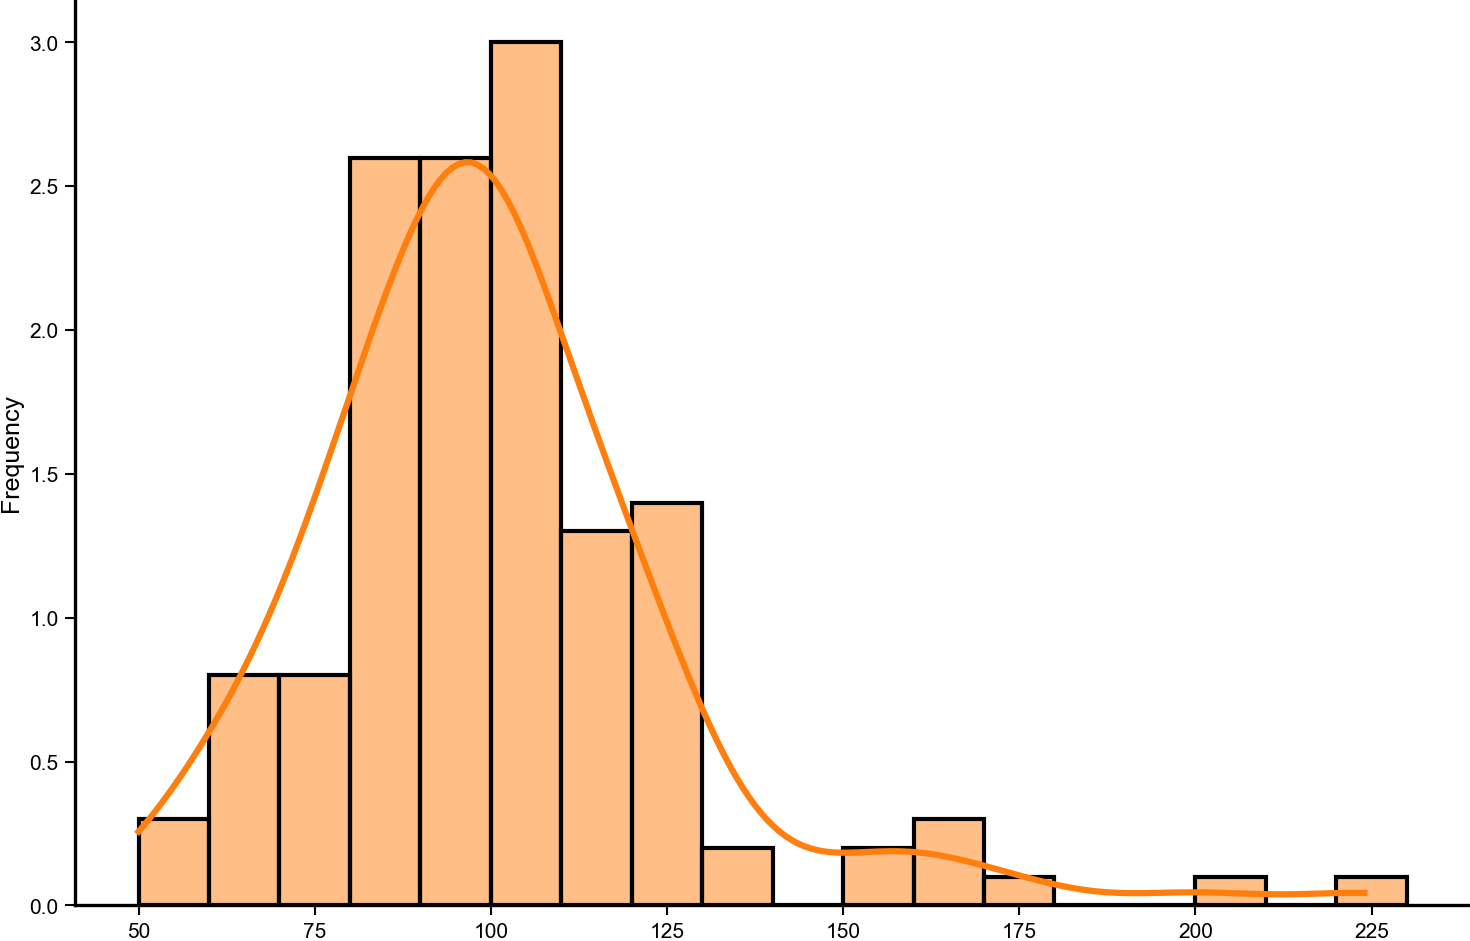

In [503]:
sns.histplot(tempi['menominee'], kde_kws=dict(cut=0), kde=True, binwidth=10, stat='frequency', color='C1')


In [ ]:
sns.histplot(tempi['maidu'], kde_kws=dict(cut=0), kde=True)
sns.ecdfplot(tempi['maidu'])

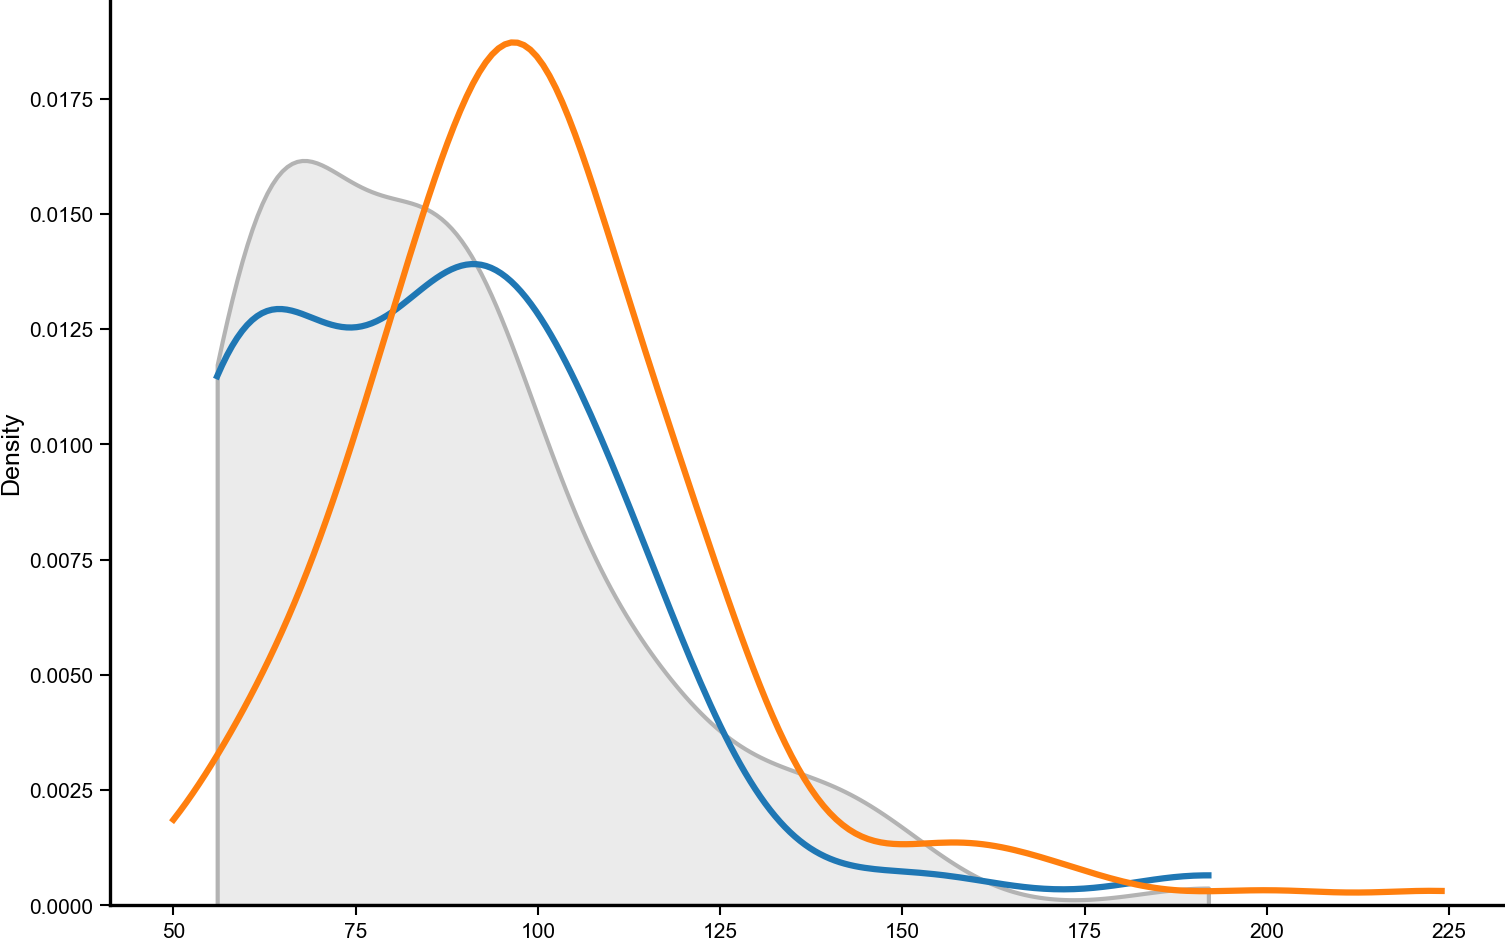

In [486]:
sns.kdeplot(tempi['maidu'], cut=0)
sns.kdeplot(tempi['menominee'], cut=0)
# sns.kdeplot(tempi['choctaw'], cut=0)

sns.kdeplot(
    np.concatenate([ tempi['maidu'], tempi['choctaw']]), cut=0, color='0.7', fill=True, )

/Users/bas/repos/papers/contour-typology/env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


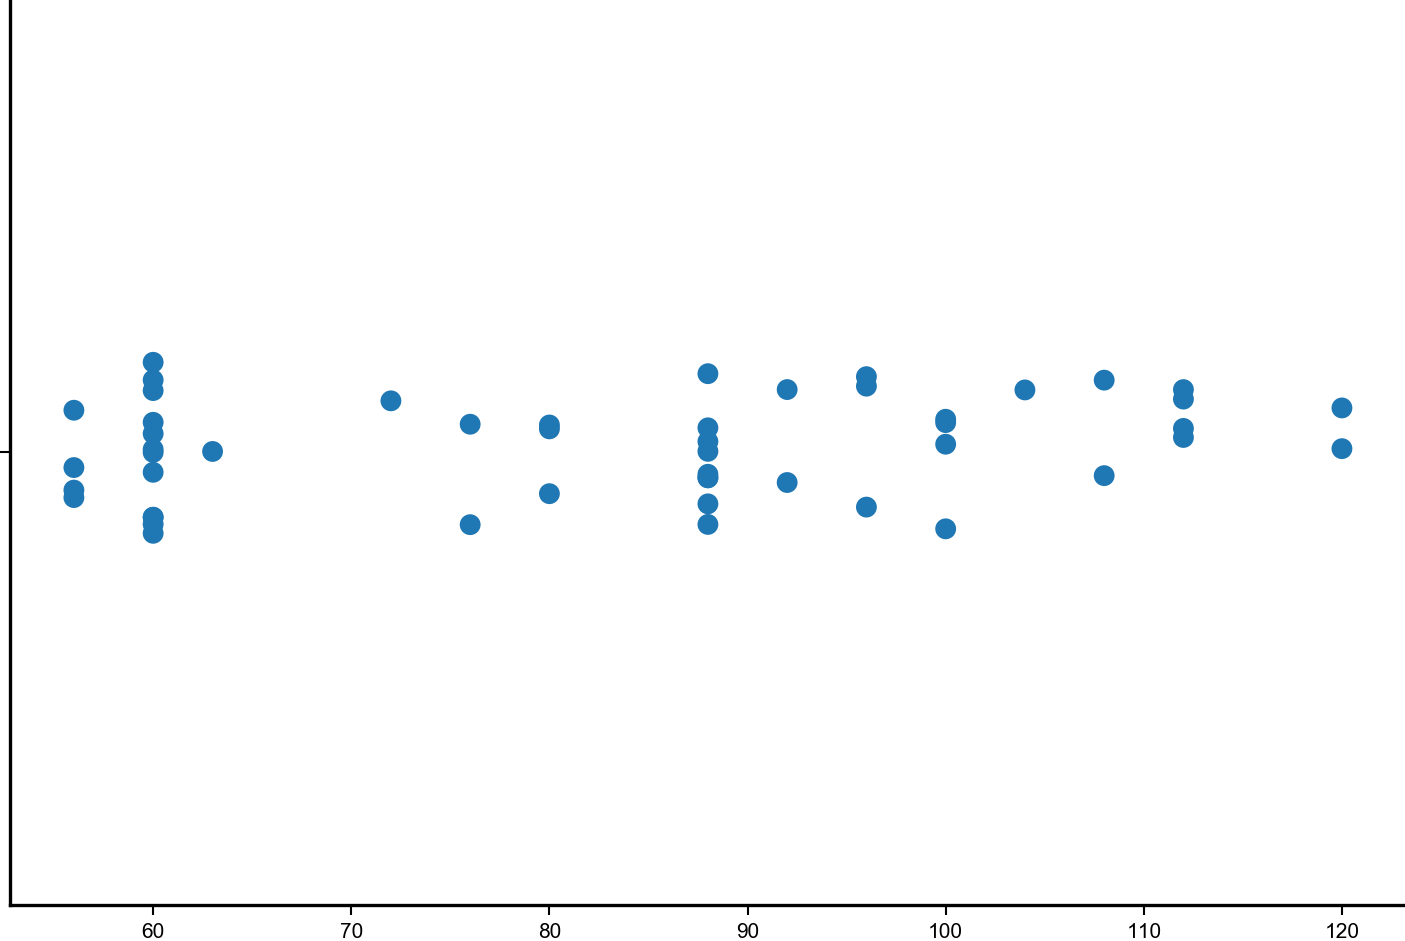

In [353]:
sns.stripplot(maidu_tempi)

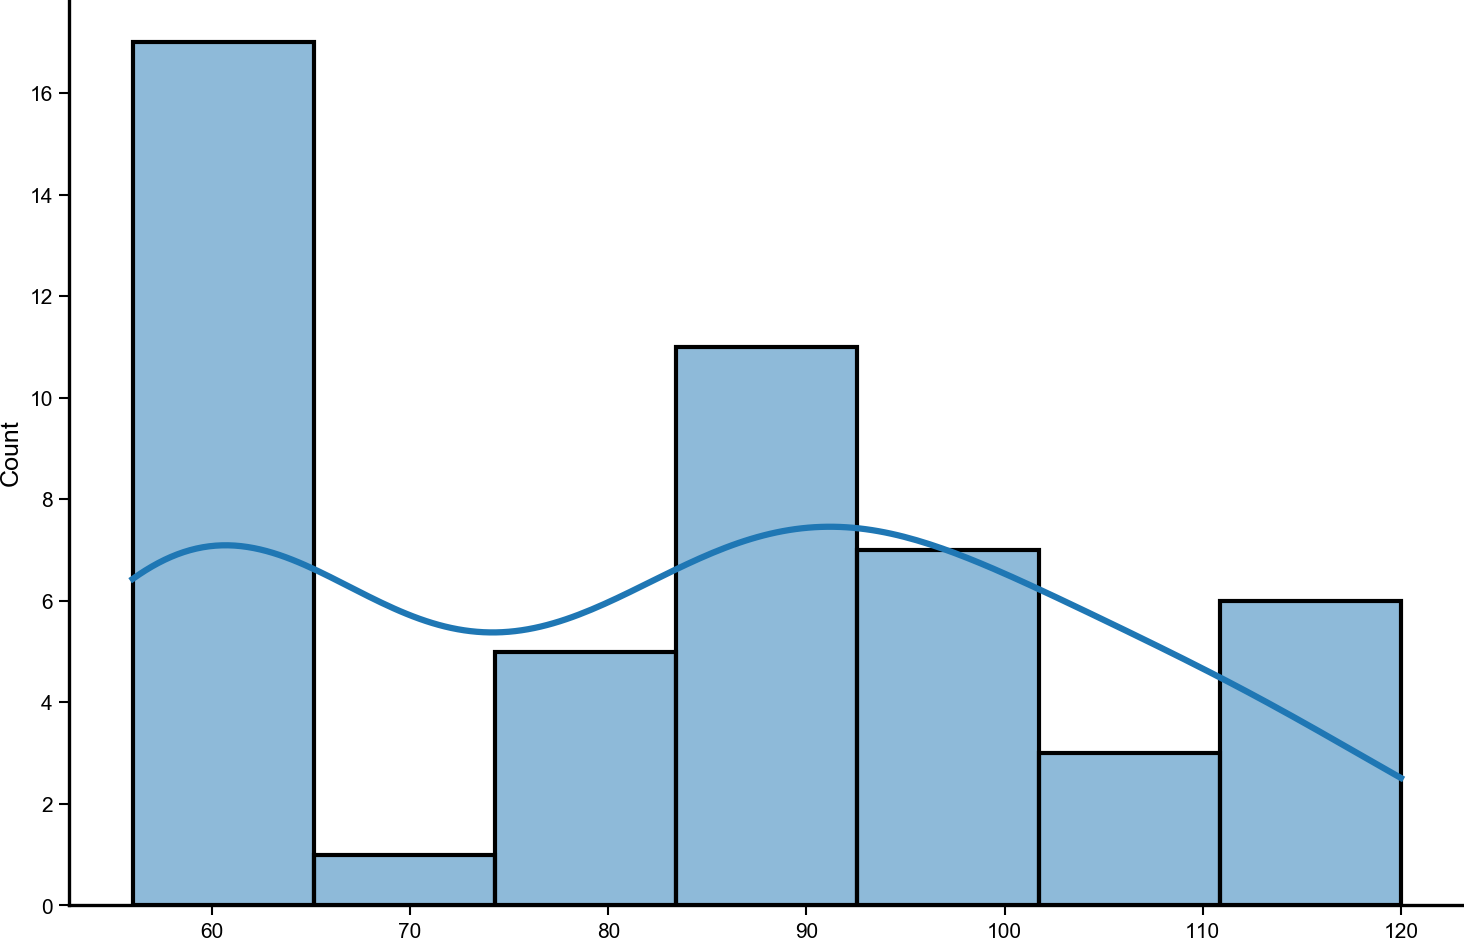

In [350]:
sns.histplot(maidu_tempi, kde=True)

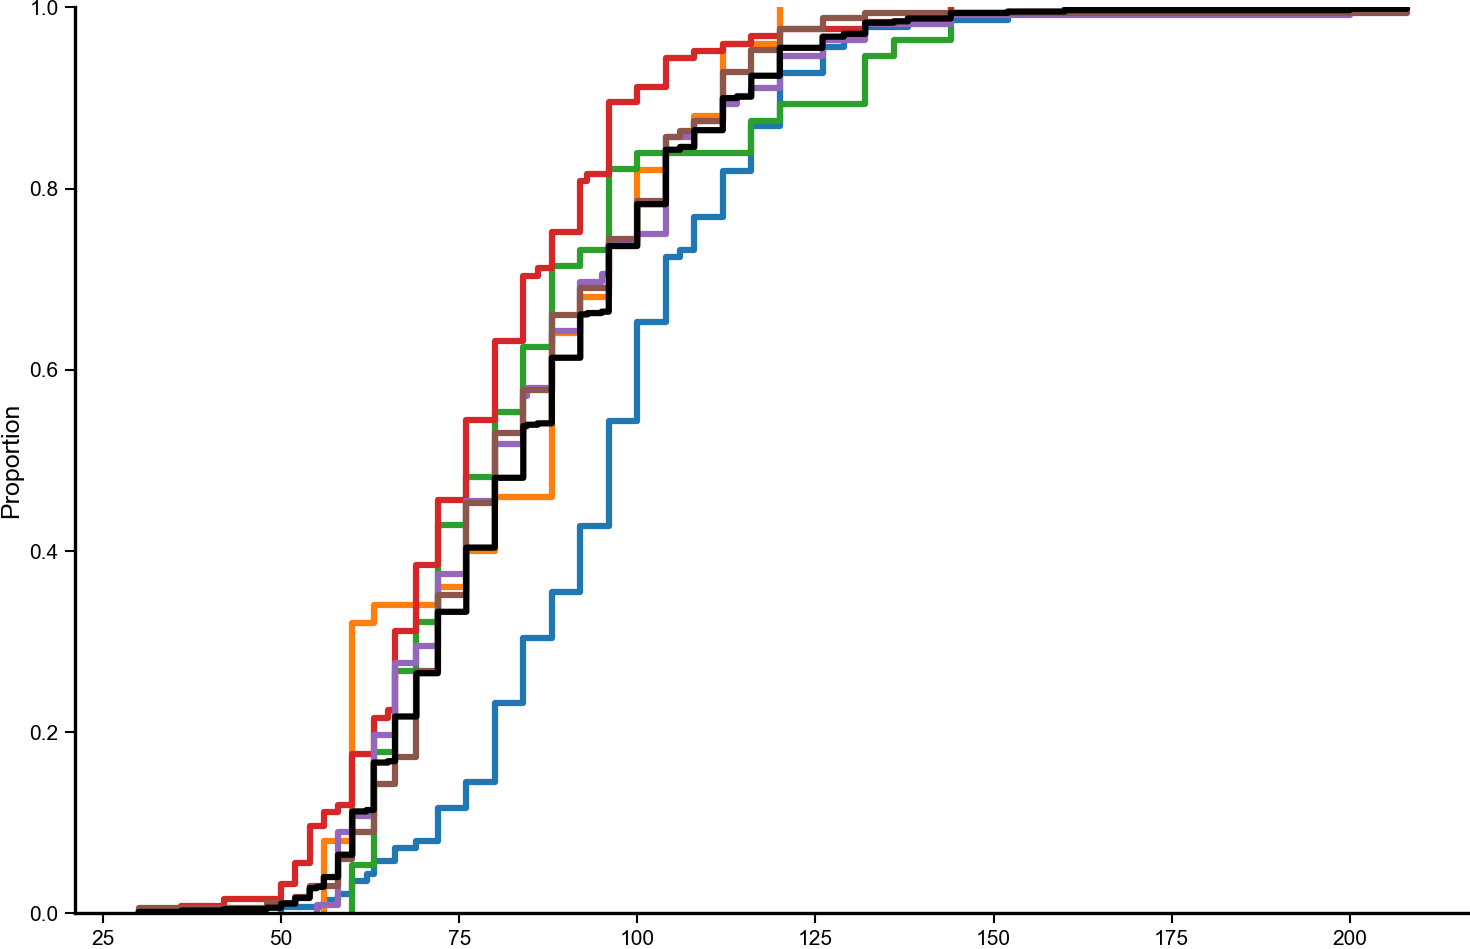

In [117]:
sns.ecdfplot(menominee_tempi)
sns.ecdfplot(maidu_tempi)
sns.ecdfplot(choctaw_tempi)
sns.ecdfplot(nootka_tempi)
sns.ecdfplot(ute_tempi)
sns.ecdfplot(papago_tempi)
sns.ecdfplot(tempi, c='k')

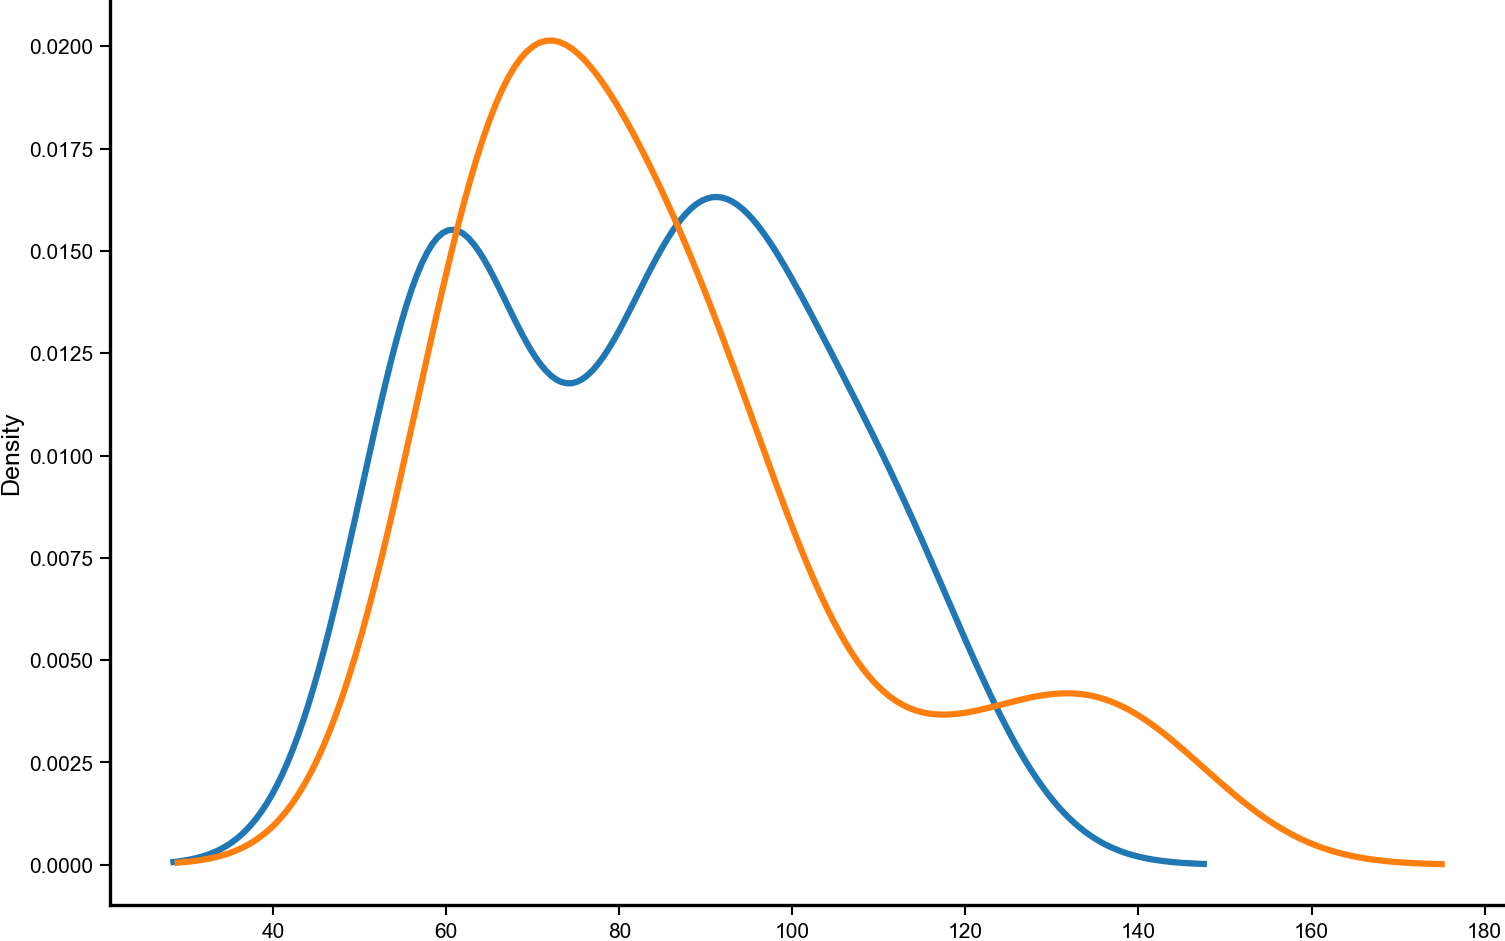

In [124]:
# sns.kdeplot(menominee_tempi)
sns.kdeplot(maidu_tempi)
sns.kdeplot(choctaw_tempi)
# sns.kdeplot(nootka_tempi)
# sns.kdeplot(ute_tempi)
# sns.kdeplot(papago_tempi)
# sns.kdeplot(tempi, c='k')

In [54]:
maidu_tempi

array([ 92.,  60.,  88.,  72.,  60.,  60.,  80.,  88.,  88., 104.,  88.,
        60.,  88.,  60.,  60.,  56.,  56.,  60.,  56.,  60.,  56.,  60.,
       108.,  80.,  92.,  60.,  96.,  96.,  60.,  60.,  76.,  88.,  63.,
        80., 112., 120., 112., 100., 120.,  76.,  88., 112., 100., 112.,
        96.,  88., 108.,  88., 100., 100.])

In [5]:
maidu['bpm_voice']

0          92
1          60
2          88
3          72
4          60
5          60
6          80
7          88
8          88
9         104
10         88
11         60
12         88
13         60
14         60
15         56
16         56
17         60
18         56
19         60
20         56
21         60
22        108
23         80
24         92
25         60
26         96
27         96
28         60
29         60
30        152
31         88
32         63
33         80
34        112
35        120
36        112
37        100
38        120
39         76
40         88
41        112
42     168|92
43        100
44        112
45        192
46     100|80
47         88
48        108
49         88
50    184|152
51        100
52        100
Name: bpm_voice, dtype: object